In [18]:
#Importações
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [26]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.abspath('..'))


from functions.clean_df import load_and_combine_csvs
from functions.clean_df import clean_dataframe
from functions.clean_df import add_confidential_flags
from functions.state_imput import apply_state_estimation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Criando o data frame

In [9]:
# Função de extração dos dados e criação do DataFrame
def injetar_csvs_no_dataframe(csv_path):
    """
    Carrega todos os arquivos CSV do diretório Database CPGF no DataFrame CPGF_df,
    adicionando a coluna 'ARQUIVO ORIGEM' com o nome do arquivo csv original.
    """
    dfs = []
    csv_files = [f for f in os.listdir(csv_path) if f.lower().endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(csv_path, file)
        df_temp = pd.read_csv(file_path,sep=';',encoding='latin-1',low_memory=False)
        df_temp['ARQUIVO ORIGEM'] = file
        dfs.append(df_temp)
    CPGF_df = pd.concat(dfs, ignore_index=True)
    return CPGF_df

In [10]:
#Usando a função
csv_path = '../raw_data'
CPGF_df = injetar_csvs_no_dataframe(csv_path)

In [11]:
# Ajustando coluna de Data
CPGF_df['DATA TRANSAÇÃO'] = pd.to_datetime(CPGF_df['DATA TRANSAÇÃO'], format='%d/%m/%Y', errors='coerce')

# Ajustando coluna de Valores
CPGF_df['VALOR TRANSAÇÃO'] = CPGF_df['VALOR TRANSAÇÃO'].astype(str).str.replace('.', '').str.replace(',', '.')
CPGF_df['VALOR TRANSAÇÃO'] = pd.to_numeric(CPGF_df['VALOR TRANSAÇÃO'], errors='coerce').fillna(0)

In [12]:
CPGF_df = CPGF_df.drop_duplicates()

In [13]:
CPGF_df_limpo = CPGF_df.copy()

## Checklist e Análises

### Checklists básicos

In [14]:
CPGF_df_limpo.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307307 entries, 0 to 392088
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   CÓDIGO ÓRGÃO SUPERIOR   307307 non-null  int64         
 1   NOME ÓRGÃO SUPERIOR     307307 non-null  object        
 2   CÓDIGO ÓRGÃO            307307 non-null  int64         
 3   NOME ÓRGÃO              307307 non-null  object        
 4   CÓDIGO UNIDADE GESTORA  307307 non-null  int64         
 5   NOME UNIDADE GESTORA    307307 non-null  object        
 6   ANO EXTRATO             307307 non-null  int64         
 7   MÊS EXTRATO             307307 non-null  int64         
 8   CPF PORTADOR            289417 non-null  object        
 9   NOME PORTADOR           307307 non-null  object        
 10  CNPJ OU CPF FAVORECIDO  307307 non-null  int64         
 11  NOME FAVORECIDO         307307 non-null  object        
 12  TRANSAÇÃO               307307 non-

In [15]:
CPGF_df_limpo.describe()

,CÓDIGO ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,CÓDIGO UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CNPJ OU CPF FAVORECIDO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO
count,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,3.073070e+05,289417,307307.000000
mean,37445.183608,32460.397918,211124.604920,2023.956506,7.002343,1.928471e+13,2024-05-31 00:34:54.494794752,590.780182
min,20000.000000,20101.000000,110001.000000,2023.000000,1.000000,-1.100000e+01,2022-10-12 00:00:00,0.040000
25%,26000.000000,25205.000000,130062.000000,2023.000000,5.000000,1.457300e+11,2023-09-13 00:00:00,104.000000
50%,36000.000000,26406.000000,158971.000000,2024.000000,7.000000,9.497253e+12,2024-06-19 00:00:00,256.850000
75%,49000.000000,40000.000000,200370.000000,2025.000000,10.000000,3.005378e+13,2025-02-25 00:00:00,600.000000
max,81000.000000,81000.000000,888310.000000,2025.000000,12.000000,9.874986e+13,2025-09-30 00:00:00,207953.600000
std,11899.873878,11519.106671,148086.823093,0.802280,3.190972,2.378397e+13,NaN,2119.947873


In [16]:
CPGF_df_limpo.isnull().sum()

CÓDIGO ÓRGÃO SUPERIOR         0
NOME ÓRGÃO SUPERIOR           0
CÓDIGO ÓRGÃO                  0
NOME ÓRGÃO                    0
CÓDIGO UNIDADE GESTORA        0
NOME UNIDADE GESTORA          0
ANO EXTRATO                   0
MÊS EXTRATO                   0
CPF PORTADOR              17890
NOME PORTADOR                 0
CNPJ OU CPF FAVORECIDO        0
NOME FAVORECIDO               0
TRANSAÇÃO                     0
DATA TRANSAÇÃO            17890
VALOR TRANSAÇÃO               0
ARQUIVO ORIGEM                0
dtype: int64

### Analisando os nulos mais a fundo

In [17]:
# Confirmando que os nulos são as mesmas linhas
nulos_cpf = CPGF_df_limpo[CPGF_df_limpo['CPF PORTADOR'].isnull()]

# Verifica se, dentro dessas linhas, a Data também é nula
print(f"Total de nulos no CPF: {len(nulos_cpf)}")
print(f"Total de nulos na data de transação (dentro das linhas nulas de CPF): {nulos_cpf['DATA TRANSAÇÃO'].isnull().sum()}")

Total de nulos no CPF: 17890
Total de nulos na data de transação (dentro das linhas nulas de CPF): 17890


#### Vendo os tipos dos gastos

In [18]:
# O que está escrito na coluna 'TRANSAÇÃO'
print("Tipos de Transação nos dados nulos:")
print(nulos_cpf['TRANSAÇÃO'].value_counts())

# O que está escrito na coluna 'NOME FAVORECIDO'
print("\nFavorecidos nos dados nulos:")
print(nulos_cpf['NOME FAVORECIDO'].value_counts())

# O que está escrito na coluna 'NOME PORTADOR'
print("\nNome do Portador nos dados nulos:")
print(nulos_cpf['NOME PORTADOR'].value_counts())


# O que está escrito na coluna 'NOME ÓRGÃO SUPERIOR'
print("\nNome do Orgão Superior nos dados nulos:")
print(nulos_cpf['NOME ÓRGÃO SUPERIOR'].value_counts())


# O que está escrito na coluna 'NOME ÓRGÃO'
print("\nNome do Orgão nos dados nulos:")
print(nulos_cpf['NOME ÓRGÃO'].value_counts())


# O que está escrito na coluna 'NOME UNIDADE GESTORA'
print("\nNome da Unidade Gestora nos dados nulos:")
print(nulos_cpf['NOME UNIDADE GESTORA'].value_counts())

Tipos de Transação nos dados nulos:
TRANSAÇÃO
Informações protegidas por sigilo    17890
Name: count, dtype: int64

Favorecidos nos dados nulos:
NOME FAVORECIDO
Sigiloso    17890
Name: count, dtype: int64

Nome do Portador nos dados nulos:
NOME PORTADOR
Sigiloso    17890
Name: count, dtype: int64

Nome do Orgão Superior nos dados nulos:
NOME ÓRGÃO SUPERIOR
Presidência da República                     11909
Ministério da Justiça e Segurança Pública     5517
Ministério da Fazenda                          319
Ministério da Defesa                           145
Name: count, dtype: int64

Nome do Orgão nos dados nulos:
NOME ÓRGÃO
Presidência da República                               11331
Polícia Federal                                         5349
Gabinete da Vice-Presidência da República                578
Fundo Constitucional do Distrito Federal                 236
Polícia Rodoviária Federal                               168
Comando da Aeronáutica                                   141
Mi

#### Vendo as datas faltantes

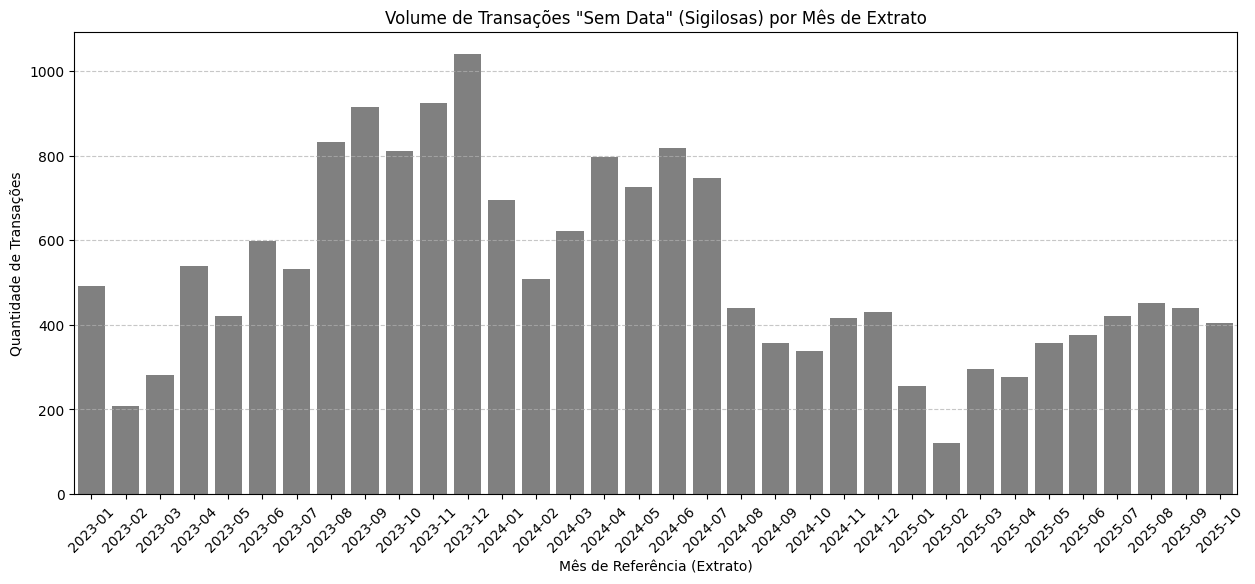

In [19]:
df_sem_data = CPGF_df_limpo[CPGF_df_limpo['DATA TRANSAÇÃO'].isnull()].copy()
distribuicao_temporal = df_sem_data.groupby(['ANO EXTRATO', 'MÊS EXTRATO']).size().reset_index(name='Quantidade')

# Ordenar
distribuicao_temporal = distribuicao_temporal.sort_values(['ANO EXTRATO', 'MÊS EXTRATO'])

# Gráfico de barras
distribuicao_temporal['Data_Ref'] = distribuicao_temporal['ANO EXTRATO'].astype(str) + '-' + distribuicao_temporal['MÊS EXTRATO'].astype(str).str.zfill(2)

plt.figure(figsize=(15, 6))
sns.barplot(data=distribuicao_temporal, x='Data_Ref', y='Quantidade', color='gray')
plt.xticks(rotation=45)
plt.title('Volume de Transações "Sem Data" (Sigilosas) por Mês de Extrato')
plt.xlabel('Mês de Referência (Extrato)')
plt.ylabel('Quantidade de Transações')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### **Proposta para os nulos:** Adicionar uma coluna que indicará se o gasto é sigiloso  e outra indicado se a data é imputada (consideramos que colocaremos na nada desses casos sempre ano-mes-01)
_Observação: Ao criar a feature DIA_DA_SEMANA, ele deve usar uma lógica condicional tipo if row['DATA_IMPUTADA'] == 1: return -1_

### Analisando Estados

In [20]:
CPGF_df_limpo['NOME ÓRGÃO'].value_counts()

NOME ÓRGÃO
Fundação Instituto Brasileiro de Geografia e Estatística                47314
Comando do Exército                                                     33393
Polícia Federal                                                         19085
Presidência da República                                                12417
Comando da Marinha                                                      12411
                                                                        ...  
Universidade Federal do Sul e Sudeste do Pará                               2
Universidade Federal do Espírito Santo                                      2
Instituto Federal de Educação, Ciência e Tecnologia de Sergipe              2
Universidade Federal do Delta do Parnaíba                                   1
Fundação Coordenação de Aperfeiçoamento de Pessoal de Nível Superior        1
Name: count, Length: 194, dtype: int64

In [21]:
CPGF_df_limpo['NOME UNIDADE GESTORA'].value_counts()

NOME UNIDADE GESTORA
SUPERINTENDENCIA ESTADUAL IBGE EM SAO PAULO     12344
INSTITUTO CHICO MENDES - SEDE                    6153
UNIVERSIDADE FEDERAL FLUMINENSE                  5938
GABINETE DE SEGURANCA INSTITUCIONAL/PR           5422
SECRETARIA DE ADMINISTRACAO/PR                   5310
                                                ...  
GERENCIA REGIONAL DA ANM - GO                       1
INST. FED. DO PARANA/CAMPUS TELEMACO BORBA          1
IFPE - CAMPUS CABO DE SANTO AGOSTINHO               1
COLEGIO PEDRO II - CAMPUS SAO CRISTOVAO III         1
COORDENACAO DE APOIO A ADM. DOS MUSEUS IBRAM        1
Name: count, Length: 1272, dtype: int64

In [22]:
termos_especificos = {
    # === CORREÇÕES DE BUGS E CASOS ESPECÍFICOS (Prioridade) ===
    'PARADA DE LUCAS': 'RJ',
    'CATARINENSE': 'SC',
    'RIO DO SUL': 'SC',
    'CONCEICAO S/A': 'RS',      # Hospital Conceição
    'TRIANGULO MINEIRO': 'MG',
    'FOZ DO IGUACU': 'PR',
    'VALES DO S.FRANC': 'DF',   # Codevasf (Sede)
    'PARNAIBA': 'DF',           # Codevasf (Sede)
    'COMUNICACAO S.A': 'DF',    # EBC
    'RECURSOS MINERAIS': 'DF',  # CPRM
    'DITEC/DPF': 'DF',

    # === CAPITAIS E GRANDES CIDADES (Mapeamento Urbano) ===
    # -- Região Norte --
    'MANAUS': 'AM', 'AMAZONIA': 'AM',
    'BELEM': 'PA', 'SANTAREM': 'PA', 'MARABA': 'PA', 'ANANINDEUA': 'PA',
    'PORTO VELHO': 'RO',
    'RIO BRANCO': 'AC',
    'BOA VISTA': 'RR',
    'MACAPA': 'AP',
    'PALMAS': 'TO', 'ARAGUAINA': 'TO',

    # -- Região Nordeste --
    'SAO LUIS': 'MA', 'IMPERATRIZ': 'MA',
    'TERESINA': 'PI', 'PARNAIBA': 'PI', # Cuidado: Parnaíba cidade vs Rio
    'FORTALEZA': 'CE', 'SOBRAL': 'CE', 'JUAZEIRO DO NORTE': 'CE',
    'NATAL': 'RN', 'MOSSORO': 'RN',
    'JOAO PESSOA': 'PB', 'CAMPINA GRANDE': 'PB',
    'RECIFE': 'PE', 'JABOATAO': 'PE', 'PETROLINA': 'PE', 'CARUARU': 'PE', 'JOAQUIM NABUCO': 'PE',
    'MACEIO': 'AL', 'ARAPIRACA': 'AL',
    'ARACAJU': 'SE',
    'SALVADOR': 'BA', 'FEIRA DE SANTANA': 'BA', 'VITORIA DA CONQUISTA': 'BA', 'CAMACARI': 'BA', 'ILHEUS': 'BA', 'GONCALO MONIZ': 'BA',

    # -- Região Centro-Oeste --
    'CUIABA': 'MT', 'VARZEA GRANDE': 'MT', 'RONDONOPOLIS': 'MT',
    'CAMPO GRANDE': 'MS', 'DOURADOS': 'MS', 'CORUMBA': 'MS',
    'GOIANIA': 'GO', 'APARECIDA DE GOIANIA': 'GO', 'ANAPOLIS': 'GO', 'RIO VERDE': 'GO', 'CRISTALINA': 'GO', 'CATALAO': 'GO',

    # -- Região Sudeste --
    'BELO HORIZONTE': 'MG', 'UBERLANDIA': 'MG', 'CONTAGEM': 'MG', 'JUIZ DE FORA': 'MG', 'BETIM': 'MG', 'OURO PRETO': 'MG', 'LAVRAS': 'MG', 'ITAJUBA': 'MG', 'ALFENAS': 'MG', 'S.J.DEL-REI': 'MG',
    'VITORIA': 'ES', 'VILA VELHA': 'ES', 'SERRA': 'ES',
    'RIO DE JANEIRO': 'RJ', 'NITEROI': 'RJ', 'SAO GONCALO': 'RJ', 'DUQUE DE CAXIAS': 'RJ', 'NOVA IGUACU': 'RJ', 'PETROPOLIS': 'RJ', 'VOLTA REDONDA': 'RJ', 'ANGRA DOS REIS': 'RJ', 'ITATIAIA': 'RJ', 'CEFET/RJ': 'RJ', 'ILHA DAS FLORES': 'RJ', 'AGULHAS NEGRAS': 'RJ', 'RESENDE': 'RJ', 'FLUMINENSE': 'RJ', 'PEDRO II': 'RJ',
    'SAO PAULO': 'SP', 'GUARULHOS': 'SP', 'CAMPINAS': 'SP', 'SAO BERNARDO': 'SP', 'SANTO ANDRE': 'SP', 'OSASCO': 'SP', 'RIBEIRAO PRETO': 'SP', 'SOROCABA': 'SP', 'SANTOS': 'SP', 'SAO CARLOS': 'SP', 'TAUBATE': 'SP',

    # -- Região Sul --
    'CURITIBA': 'PR', 'LONDRINA': 'PR', 'MARINGA': 'PR', 'PONTA GROSSA': 'PR', 'CASCAVEL': 'PR',
    'FLORIANOPOLIS': 'SC', 'JOINVILLE': 'SC', 'BLUMENAU': 'SC', 'CHAPECO': 'SC', 'ITAJAI': 'SC',
    'PORTO ALEGRE': 'RS', 'CAXIAS DO SUL': 'RS', 'PELOTAS': 'RS', 'CANOAS': 'RS', 'SANTA MARIA': 'RS', 'RIO GRANDE': 'RS', 'PAMPA': 'RS',

    # -- Distrito Federal (Termos Nacionais/Sedes) --
    'BRASILIA': 'DF', 'INTELIGENCIA': 'DF', 'ABIN': 'DF', 'CHICO MENDES': 'DF',
    'NACIONAL': 'DF', 'BRASILEIRA': 'DF', 'CENTRAL': 'DF', 'SUPERIOR': 'DF',
    'SIT': 'DF', 'CODEVASF': 'DF',
    'FNDE': 'DF', 'INEP': 'DF', 'CAPES': 'DF', 'CNPQ': 'DF', 'EBSERH': 'DF',
    'ESPLANADA': 'DF', 'ADMINISTRACAO INTERNA': 'DF'
}

# SIGLAS DE ESTADOS
estados_map = {
    'AC': ['ACRE', '/AC', '- AC'], 'AL': ['ALAGOAS', '/AL', '- AL'],
    'AP': ['AMAPA', '/AP', '- AP'], 'AM': ['AMAZONAS', '/AM', '- AM'],
    'BA': ['BAHIA', '/BA', '- BA'], 'CE': ['CEARA', '/CE', '- CE'],
    'DF': ['DISTRITO FEDERAL', 'BRASILIA', '/DF', '- DF', 'PRESIDENCIA', 'MINISTERIO', 'COORDENACAO'],
    'ES': ['ESPIRITO SANTO', '/ES', '- ES'], 'GO': ['GOIAS', '/GO', '- GO'],
    'MA': ['MARANHAO', '/MA', '- MA'], 'MT': ['MATO GROSSO', '/MT', '- MT'],
    'MS': ['MATO GROSSO DO SUL', '/MS', '- MS'], 'MG': ['MINAS GERAIS', '/MG', '- MG'],
    'PB': ['PARAIBA', '/PB', '- PB'], 'PR': ['PARANA', '/PR', '- PR'], 'PA': ['PARA', '/PA', '- PA'],
    'PE': ['PERNAMBUCO', '/PE', '- PE'], 'PI': ['PIAUI', '/PI', '- PI'],
    'RJ': ['RIO DE JANEIRO', '/RJ', '- RJ'],
    'RN': ['RIO GRANDE DO NORTE', '/RN', '- RN'], 'RS': ['RIO GRANDE DO SUL', '/RS', '- RS'],
    'RO': ['RONDONIA', '/RO', '- RO'], 'RR': ['RORAIMA', '/RR', '- RR'],
    'SC': ['SANTA CATARINA', '/SC', '- SC'], 'SP': ['SAO PAULO', '/SP', '- SP'],
    'SE': ['SERGIPE', '/SE', '- SE'], 'TO': ['TOCANTINS', '/TO', '- TO']
}
siglas_confiaveis = list(estados_map.keys())

def estimar_estado(linha):
    texto = str(linha['NOME ÓRGÃO']) + " " + str(linha['NOME UNIDADE GESTORA'])
    texto = texto.upper()

    # de/para com termos específicos
    for termo, uf in termos_especificos.items():
        if termo in texto:
            return uf

    # Limpeza de termos irrelevantes
    texto = texto.replace(" SEDE ", " ")
    texto = texto.replace("PARADA", "")

    #  Termos presidenciais
    termos_presidencia = ['GABINETE DE SEGURANCA', 'SECRETARIA DE ADMINISTRACAO/PR', 'PRESIDENCIA DA REPUBLICA']
    for termo in termos_presidencia:
        if termo in texto:
            return 'DF'

    # Busca com preposições
    padrao_preposicao = r'\b(NO|NA|DO|DA|DE|EM|AO)\s+(' + '|'.join(siglas_confiaveis) + r')\b'
    match = re.search(padrao_preposicao, texto)
    if match:
        return match.group(2)

    #  Busca por siglas ou nomes completos
    for uf, termos in estados_map.items():
        for termo in termos:
            if len(termo) > 3:
                if termo in texto:
                    return uf
            elif re.search(r'\b' + re.escape(termo) + r'\b', texto):
                 return uf

    return 'UNIÃO'


CPGF_df_limpo['ESTADO_ESTIMADO'] = CPGF_df_limpo.apply(estimar_estado, axis=1)

print("\n--- Ranking Final dos Estados ---")
print(CPGF_df_limpo['ESTADO_ESTIMADO'].value_counts().head(25))


--- Ranking Final dos Estados ---
ESTADO_ESTIMADO
DF       86008
UNIÃO    56553
RS       24706
MG       19113
SP       16994
RJ       16247
PA        8458
SC        7867
GO        7546
AM        7289
BA        6635
PR        6293
PE        5180
MT        5126
TO        3613
MA        3592
ES        3450
RO        2799
MS        2590
AL        2574
SE        2353
PI        2210
PB        2146
CE        2104
AP        1684
Name: count, dtype: int64


In [23]:
summary_estado = (
    CPGF_df_limpo.groupby("ESTADO_ESTIMADO")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("sum", ascending=False)
)

summary_estado

,count,min,Q1,median,Q3,max,mean,sum,std
ESTADO_ESTIMADO,,,,,,,,,
DF,86008,0.20,119.5900,271.935,650.000,207953.60,834.229284,71750392.26,3645.956887
UNIÃO,56553,0.04,102.5000,250.180,597.900,189650.00,576.819606,32620879.17,1605.118628
RS,24706,0.80,89.9825,234.245,560.000,36048.00,422.136085,10429294.12,691.225276
RJ,16247,1.08,100.0000,266.150,686.040,26000.00,581.257184,9443685.47,966.838798
MG,19113,0.20,80.0000,190.000,465.000,14750.00,379.021626,7244240.33,532.005477
AM,7289,1.00,198.0000,490.000,1000.000,12900.00,745.565881,5434429.71,914.446783
SP,16994,1.49,74.9500,156.000,400.000,12358.40,312.120127,5304169.43,465.488937
PA,8458,2.00,159.1875,400.000,950.000,15000.00,576.265555,4874054.06,712.876697
GO,7546,0.10,115.0000,287.320,700.000,19999.00,538.103671,4060530.30,755.413832


#### **Proposta para os Estados:** Fazer a validação somente por nome de cidade e manter os postos regionais (que em sua maioria são militares) como união

### Análise por valor da transação

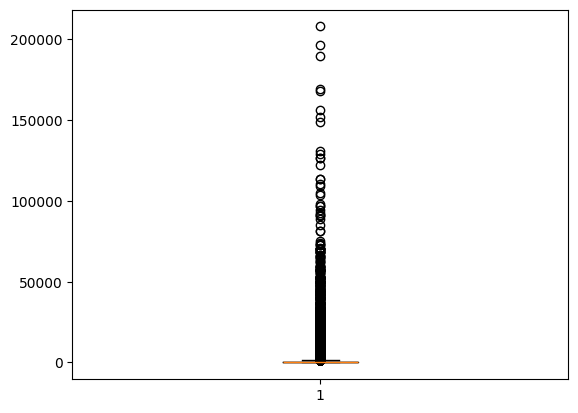

In [24]:
plt.boxplot(CPGF_df_limpo['VALOR TRANSAÇÃO'])
plt.show();

In [25]:
# Visão por órgão superior
summary_orgao = (
    CPGF_df_limpo.groupby("NOME ÓRGÃO SUPERIOR")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_orgao

,count,min,Q1,median,Q3,max,mean,sum,std
NOME ÓRGÃO SUPERIOR,,,,,,,,,
Ministério do Desenvolvimento e Assistência,3,11585.55,12837.4000,14089.250,14165.3750,14241.50,13305.433333,39916.30,1491.406727
Ministério dos Direitos Humanos e Cidadania,74,118.00,450.0000,1385.995,2232.1200,8950.00,1579.412568,116876.53,1350.702487
Ministério da Pesca e Aquicultura,19,179.90,575.0000,1000.000,2137.0000,2833.00,1341.494211,25488.39,868.246257
Ministério do Meio Ambiente e Mudança do Cl,7669,0.30,200.0000,576.000,1150.0000,30000.00,991.690733,7605276.23,1602.917294
Ministério da Justiça e Segurança Pública,22323,0.60,200.0000,515.730,1000.0000,122038.19,904.341515,20187615.64,2035.106263
Controladoria-Geral da União,211,13.80,223.7500,488.600,1100.0000,4762.50,792.444834,167205.86,796.780426
Ministério das Cidades,1131,0.89,188.3500,465.880,951.0000,4095.40,619.124058,700229.31,530.329860
Ministério das Comunicações,424,1.90,180.0000,400.000,989.5625,1800.00,559.520024,237236.49,458.541021
Ministério de Portos e Aeroportos,247,10.90,138.4000,396.000,899.4500,5960.00,630.908462,155834.39,754.193649


In [26]:
# Visão por unidade gestora
summary_unidade_gestora = (
    CPGF_df_limpo.groupby("NOME UNIDADE GESTORA")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_unidade_gestora

,count,min,Q1,median,Q3,max,mean,sum,std
NOME UNIDADE GESTORA,,,,,,,,,
COORDENACAO GERAL DE LICITACOES E CONTRATOS.,3,11585.55,12837.400,14089.25,14165.375,14241.50,13305.433333,39916.30,1491.406727
62 BATALHAO DE INFANTARIA,5,730.00,1000.000,10000.00,20000.000,49000.00,16146.000000,80730.00,19994.163648
1º BATALHAO DE INFANTARIA MECANIZADO (ES),1,6957.91,6957.910,6957.91,6957.910,6957.91,6957.910000,6957.91,NaN
FCDF±SSP ± POLICIA MILITAR DO DF,11,677.74,1670.550,6399.84,15674.500,29897.67,9831.068182,108141.75,9832.965975
BATALHAO MANUTENCAO E SUPRIMENTO DE ARMAMENTO,3,2760.00,3994.000,5228.00,6879.750,8531.50,5506.500000,16519.50,2895.811587
...,...,...,...,...,...,...,...,...,...
DELEGACIA DA RFB EM VOLTA REDONDA,4,14.90,14.900,17.40,19.900,19.90,17.400000,69.60,2.886751
COLEGIO MILITAR DE JUIZ DE FORA,2,9.90,10.425,10.95,11.475,12.00,10.950000,21.90,1.484924
INST.FED.DO RN/CAMPUS NATAL - CENTRAL,1,8.90,8.900,8.90,8.900,8.90,8.900000,8.90,NaN


In [27]:
# Visão por tipo de transação
summary_transacao = (
    CPGF_df_limpo.groupby("TRANSAÇÃO")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_transacao

,count,min,Q1,median,Q3,max,mean,sum,std
TRANSAÇÃO,,,,,,,,,
COMP A/V-SOL DISP C/CLI-R$ ANT VENC,1,1300.00,1300.0000,1300.000,1300.000,1300.00,1300.000000,1.300000e+03,NaN
SAQUE - INT$ - APRES,982,17.01,683.2750,1178.630,2667.295,4979.48,1547.556578,1.519701e+06,1179.341834
SAQUE CASH/ATM BB,29212,2.00,190.0000,470.000,850.000,1000.00,504.291592,1.473137e+07,345.669502
Informações protegidas por sigilo,17890,0.20,145.5375,412.035,1000.000,207953.60,1957.473547,3.501920e+07,7400.901631
COMPRA A/V - R$ - APRES,256190,0.04,99.9700,239.400,549.000,189650.00,496.433868,1.271814e+08,1049.761378
COMPRA A/V - INT$ - APRES,3027,0.06,49.5200,162.340,460.980,122038.19,1022.997146,3.096612e+06,5034.320662
CPP LOJISTA TRF P/FATURA - REAL,2,91.07,91.0700,91.070,91.070,91.07,91.070000,1.821400e+02,0.000000
SAQUE - R$ - APRES,3,50.00,65.0000,80.000,540.000,1000.00,376.666667,1.130000e+03,540.030863


In [28]:
# Visão por portador
CPGF_df_limpo['CHAVE_PORTADOR'] = CPGF_df_limpo['CPF PORTADOR'] + CPGF_df_limpo['NOME PORTADOR']
summary_portador = (
    CPGF_df_limpo.groupby("CHAVE_PORTADOR")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_portador

,count,min,Q1,median,Q3,max,mean,sum,std
CHAVE_PORTADOR,,,,,,,,,
***.651.497-**JOAO GABRIEL CONCEICAO MARQUES,1,189650.00,189650.00,189650.00,189650.00,189650.00,189650.00,189650.00,NaN
***.425.562-**MATHEUS GUTTEMBERG ROCHA DOS SANTOS,2,52500.00,81375.00,110250.00,139125.00,168000.00,110250.00,220500.00,81670.833227
***.040.135-**MATHEUS OLIVEIRA COSTA,1,68479.74,68479.74,68479.74,68479.74,68479.74,68479.74,68479.74,NaN
***.844.951-**EUCIMAR DIOGENES DE MEDEIROS,1,29897.67,29897.67,29897.67,29897.67,29897.67,29897.67,29897.67,NaN
***.802.502-**MILTON MARTINS DA PENHA FILHO,1,29891.24,29891.24,29891.24,29891.24,29891.24,29891.24,29891.24,NaN
...,...,...,...,...,...,...,...,...,...
***.007.398-**ALAN CESAR DA CRUZ,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN
***.672.704-**LEANDRO FERREIRA DA SILVA,2,1.00,1.00,1.00,1.00,1.00,1.00,2.00,0.000000
***.890.293-**GIOVANNI MENDES GOES,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN


In [29]:
# Visão por favorecido
summary_favorecido = (
    CPGF_df_limpo.groupby("CNPJ OU CPF FAVORECIDO")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_favorecido

,count,min,Q1,median,Q3,max,mean,sum,std
CNPJ OU CPF FAVORECIDO,,,,,,,,,
63859961000176,2,52500.00,86787.50,121075.00,155362.50,189650.00,121075.00,242150.00,96979.695040
1200121000140,2,5700.00,46275.00,86850.00,127425.00,168000.00,86850.00,173700.00,114763.430587
5917540000158,1,68589.15,68589.15,68589.15,68589.15,68589.15,68589.15,68589.15,NaN
31702576000124,1,32999.00,32999.00,32999.00,32999.00,32999.00,32999.00,32999.00,NaN
26398202000127,1,32000.00,32000.00,32000.00,32000.00,32000.00,32000.00,32000.00,NaN
...,...,...,...,...,...,...,...,...,...
68859465320,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN
15248673000132,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN
73676829387,4,1.00,1.00,1.00,1.00,1.00,1.00,4.00,0.000000


### Analise de tipo de transação (Saque)

In [30]:
# Filtrando apenas as transações de Saque
saque_dinheiro = CPGF_df_limpo[
    CPGF_df_limpo['TRANSAÇÃO'].isin([
        'SAQUE CASH/ATM BB',
        'SAQUE - INT$ - APRES',
        'SAQUE - R$ - APRES',
    ])
]

# Agrupando e somando
saque_dinheiro_por_orgao = (
    saque_dinheiro.groupby(['CPF PORTADOR', 'NOME ÓRGÃO'])['VALOR TRANSAÇÃO']
    .agg(['count', 'sum'])
    .sort_values('sum', ascending=False)
)

# Exibindo o resultado
saque_dinheiro_por_orgao

,,count,sum
CPF PORTADOR,NOME ÓRGÃO,,
***.457.551-**,Polícia Federal,93,277966.52
***.804.607-**,Polícia Federal,66,193974.03
***.540.267-**,Fundação Instituto Brasileiro de Geografia e Estatística,189,152870.00
***.429.232-**,Fundação Instituto Brasileiro de Geografia e Estatística,189,149825.00
***.687.862-**,Fundação Instituto Brasileiro de Geografia e Estatística,166,142500.00
...,...,...,...
***.704.205-**,Polícia Federal,1,10.00
***.600.679-**,Fundação Instituto Brasileiro de Geografia e Estatística,1,10.00
***.745.346-**,Companhia de Desenvolvimento dos Vales do São Francisco e do Parnaíba,1,10.00


In [31]:
gasto_por_orgao = (
    CPGF_df_limpo
        .groupby('NOME ÓRGÃO')['VALOR TRANSAÇÃO']
        .agg(['count', 'sum', 'mean'])
        .sort_values('sum', ascending=False)
)
gasto_por_orgao

,count,sum,mean
NOME ÓRGÃO,,,
Presidência da República,12417,29221424.40,2353.340130
Comando do Exército,33393,23049429.19,690.247333
Polícia Federal,19085,18043830.17,945.445647
Fundação Instituto Brasileiro de Geografia e Estatística,47314,17837510.20,377.002794
Comando da Marinha,12411,6962379.60,560.984578
...,...,...,...
"Instituto Federal de Educação, Ciência e Tecnologia de Sergipe",2,900.00,450.000000
Fundação Coordenação de Aperfeiçoamento de Pessoal de Nível Superior,1,377.30,377.300000
Universidade Federal do Espírito Santo,2,359.94,179.970000


##  Alterações na base de dado

### Padding de CPF/CNPJ
Pelos dados mais comuns é possível entender que muitos dos dados de documentos do favorecido estão dessa forma por falta do 0 à esquerda. Exemplo '1060735000173' tem como final um claro comportamento de documento CNPJ /0001-73 faltando somente um zero à esquera para completar o documento.
Portanto faremos um padding para equalizar os CPFs nos 11 digitos e os CNPJs nos 14:

In [32]:
tamanhos_problematicos = [2, 4, 6, 7, 8, 9, 10, 12, 13]
serie_tamanhos = CPGF_df['CNPJ OU CPF FAVORECIDO'].str.len()

CPGF_df['CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df['CNPJ OU CPF FAVORECIDO']

mascara_cpf_fix = (serie_tamanhos >= 8) & (serie_tamanhos <= 10)
mascara_cnpj_fix = (serie_tamanhos == 12) | (serie_tamanhos == 13)

# Padding CPF
CPGF_df.loc[mascara_cpf_fix, 'CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df['CNPJ OU CPF FAVORECIDO'][mascara_cpf_fix].str.pad(width=11, side='left', fillchar='0')

# Padding CNPJ
CPGF_df.loc[mascara_cnpj_fix, 'CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df['CNPJ OU CPF FAVORECIDO'][mascara_cnpj_fix].str.pad(width=14, side='left', fillchar='0')

AttributeError: Can only use .str accessor with string values!

In [ ]:
# Classificação do tipo de favorecido
condicoes = [(serie_tamanhos == 11), (serie_tamanhos == 14), (serie_tamanhos == 2)]
categorias = ['CPF','CNPJ','NAO_INFORMADO']

CPGF_df['TIPO FAVORECIDO'] = np.select(condicoes,categorias,default='INVALIDO')

In [ ]:
# Drop nos favorecidos não classificados
linhas_para_dropar = CPGF_df[CPGF_df['TIPO FAVORECIDO'] == 'INVALIDO'].index
CPGF_df = CPGF_df.drop(linhas_para_dropar)

In [ ]:
# Analisando a nova feature
print("Contagem de linhas por categoria:")
print(CPGF_df['TIPO FAVORECIDO'] .value_counts())

Contagem de linhas por categoria:
TIPO FAVORECIDO
CNPJ             151756
NAO_INFORMADO     46915
CPF                7157
Name: count, dtype: int64


In [ ]:
# Substituindo a CNPJ OU CPF FAVORECIDO pela CNPJ OU CPF FAVORECIDO CORRIGIDO
CPGF_df = CPGF_df.drop(columns=['CNPJ OU CPF FAVORECIDO'])
CPGF_df = CPGF_df.rename(columns={'CNPJ OU CPF FAVORECIDO CORRIGIDO':'CNPJ OU CPF FAVORECIDO'})

### Criar coluna para dados sigilosos

In [ ]:
CPGF_df['DADO_SIGILOSO'] = (CPGF_df['NOME FAVORECIDO'] == 'Sigiloso').astype(int)

print(CPGF_df['DADO_SIGILOSO'].value_counts())

DADO_SIGILOSO
0    289417
1     17890
Name: count, dtype: int64


### Imputar datas faltantes

In [ ]:
datas_nulas = CPGF_df['DATA TRANSAÇÃO'].isnull()

datas_artificiais = pd.to_datetime(
    CPGF_df.loc[datas_nulas, 'ANO EXTRATO'].astype(str) + '-' +
    CPGF_df.loc[datas_nulas, 'MÊS EXTRATO'].astype(str) + '-01'
)

CPGF_df.loc[datas_nulas, 'DATA TRANSAÇÃO'] = datas_artificiais

print(f"Linhas imputadas: {datas_nulas.sum()}")
print(f"Nulos restantes em DATA TRANSAÇÃO: {CPGF_df['DATA TRANSAÇÃO'].isnull().sum()}")

Linhas imputadas: 0
Nulos restantes em DATA TRANSAÇÃO: 0


In [ ]:
CPGF_df.isnull().sum()

CÓDIGO ÓRGÃO SUPERIOR         0
NOME ÓRGÃO SUPERIOR           0
CÓDIGO ÓRGÃO                  0
NOME ÓRGÃO                    0
CÓDIGO UNIDADE GESTORA        0
NOME UNIDADE GESTORA          0
ANO EXTRATO                   0
MÊS EXTRATO                   0
CPF PORTADOR              17890
NOME PORTADOR                 0
CNPJ OU CPF FAVORECIDO        0
NOME FAVORECIDO               0
TRANSAÇÃO                     0
DATA TRANSAÇÃO                0
VALOR TRANSAÇÃO               0
ARQUIVO ORIGEM                0
DADO_SIGILOSO                 0
dtype: int64

### Imputar estado

In [ ]:
mapa_cidades = {
    # Rio de Janeiro (RJ)
    'RIO DE JANEIRO': 'RJ', 'NITEROI': 'RJ', 'SAO GONCALO': 'RJ',
    'DUQUE DE CAXIAS': 'RJ', 'NOVA IGUACU': 'RJ', 'PETROPOLIS': 'RJ',
    'VOLTA REDONDA': 'RJ', 'ANGRA DOS REIS': 'RJ', 'ITATIAIA': 'RJ',
    'RESENDE': 'RJ', 'PARADA DE LUCAS': 'RJ', 'FLUMINENSE': 'RJ',
    'PEDRO II': 'RJ', 'ILHA DAS FLORES': 'RJ', 'AGULHAS NEGRAS': 'RJ',

    # São Paulo (SP)
    'SAO PAULO': 'SP', 'GUARULHOS': 'SP', 'CAMPINAS': 'SP',
    'SAO BERNARDO': 'SP', 'SANTO ANDRE': 'SP', 'OSASCO': 'SP',
    'RIBEIRAO PRETO': 'SP', 'SOROCABA': 'SP', 'SANTOS': 'SP',
    'SAO CARLOS': 'SP', 'TAUBATE': 'SP',

    # Minas Gerais (MG)
    'BELO HORIZONTE': 'MG', 'UBERLANDIA': 'MG', 'JUIZ DE FORA': 'MG',
    'OURO PRETO': 'MG', 'LAVRAS': 'MG', 'ITAJUBA': 'MG', 'ALFENAS': 'MG',
    'SAO JOAO DEL REI': 'MG', 'S.J.DEL-REI': 'MG', 'TRIANGULO MINEIRO': 'MG',

    # Espírito Santo (ES)
    'VITORIA': 'ES', 'VILA VELHA': 'ES',

    # Rio Grande do Sul (RS)
    'PORTO ALEGRE': 'RS', 'CAXIAS DO SUL': 'RS', 'PELOTAS': 'RS',
    'CANOAS': 'RS', 'SANTA MARIA': 'RS', 'RIO GRANDE': 'RS',
    'CONCEICAO S/A': 'RS', 'PAMPA': 'RS',

    # Paraná (PR)
    'CURITIBA': 'PR', 'LONDRINA': 'PR', 'MARINGA': 'PR',
    'PONTA GROSSA': 'PR', 'CASCAVEL': 'PR', 'FOZ DO IGUACU': 'PR',

    # Santa Catarina (SC)
    'FLORIANOPOLIS': 'SC', 'JOINVILLE': 'SC', 'BLUMENAU': 'SC',
    'CHAPECO': 'SC', 'ITAJAI': 'SC', 'RIO DO SUL': 'SC',
    'CATARINENSE': 'SC',

    # Capitais e Polos Norte/Nordeste/Centro
    'BRASILIA': 'DF', 'MANAUS': 'AM', 'BELEM': 'PA', 'SANTAREM': 'PA',
    'PORTO VELHO': 'RO', 'RIO BRANCO': 'AC', 'BOA VISTA': 'RR',
    'MACAPA': 'AP', 'PALMAS': 'TO',
    'SAO LUIS': 'MA', 'TERESINA': 'PI', 'FORTALEZA': 'CE',
    'NATAL': 'RN', 'JOAO PESSOA': 'PB', 'RECIFE': 'PE', 'MACEIO': 'AL',
    'ARACAJU': 'SE', 'SALVADOR': 'BA', 'FEIRA DE SANTANA': 'BA',
    'GONCALO MONIZ': 'BA', 'CUIABA': 'MT', 'CAMPO GRANDE': 'MS',
    'GOIANIA': 'GO', 'RIO VERDE': 'GO',

    # Termos Nacionais (Forçam DF)
    'NACIONAL': 'DF', 'BRASILEIRA': 'DF', 'CENTRAL': 'DF', 'SUPERIOR': 'DF',
    'CODEVASF': 'DF', 'FNDE': 'DF', 'INEP': 'DF', 'EBSERH': 'DF',
    'SIT': 'DF', 'PARNAIBA': 'DF', 'VALES DO S.FRANC': 'DF',
    'COMUNICACAO S.A': 'DF', 'RECURSOS MINERAIS': 'DF', 'DITEC/DPF': 'DF',
    'INTELIGENCIA': 'DF', 'ABIN': 'DF', 'CNPQ': 'DF', 'CAPES': 'DF'
}

# MAPA DE ESTADOS (Siglas e Nomes)
mapa_estados = {
    'AC': ['ACRE', '/AC', '- AC'], 'AL': ['ALAGOAS', '/AL', '- AL'],
    'AP': ['AMAPA', '/AP', '- AP'], 'AM': ['AMAZONAS', '/AM', '- AM'],
    'BA': ['BAHIA', '/BA', '- BA'], 'CE': ['CEARA', '/CE', '- CE'],
    'DF': ['DISTRITO FEDERAL', 'BRASILIA', '/DF', '- DF'],
    'ES': ['ESPIRITO SANTO', '/ES', '- ES'], 'GO': ['GOIAS', '/GO', '- GO'],
    'MA': ['MARANHAO', '/MA', '- MA'], 'MT': ['MATO GROSSO', '/MT', '- MT'],
    'MS': ['MATO GROSSO DO SUL', '/MS', '- MS'], 'MG': ['MINAS GERAIS', '/MG', '- MG'],
    'PB': ['PARAIBA', '/PB', '- PB'], 'PR': ['PARANA', '/PR', '- PR'], 'PA': ['PARA', '/PA', '- PA'],
    'PE': ['PERNAMBUCO', '/PE', '- PE'], 'PI': ['PIAUI', '/PI', '- PI'],
    'RJ': ['RIO DE JANEIRO', '/RJ', '- RJ'],
    'RN': ['RIO GRANDE DO NORTE', '/RN', '- RN'], 'RS': ['RIO GRANDE DO SUL', '/RS', '- RS'],
    'RO': ['RONDONIA', '/RO', '- RO'], 'RR': ['RORAIMA', '/RR', '- RR'],
    'SC': ['SANTA CATARINA', '/SC', '- SC'], 'SP': ['SAO PAULO', '/SP', '- SP'],
    'SE': ['SERGIPE', '/SE', '- SE'], 'TO': ['TOCANTINS', '/TO', '- TO']
}
siglas_confiaveis = list(mapa_estados.keys())

def estimar_estado(linha):
    texto = str(linha['NOME ÓRGÃO']) + " " + str(linha['NOME UNIDADE GESTORA'])
    texto = texto.upper()

    for cidade, uf in mapa_cidades.items():
        if cidade in texto:
            return uf

    texto = texto.replace(" SEDE ", " ")
    texto = texto.replace("PARADA", "")  # Remove para não confundir com PARÁ (PA)

    if 'PRESIDENCIA DA REPUBLICA' in texto or 'GABINETE DE SEGURANCA' in texto:
        return 'DF'

    padrao_preposicao = r'\b(NO|NA|DO|DA|DE|EM|AO)\s+(' + '|'.join(siglas_confiaveis) + r')\b'
    match = re.search(padrao_preposicao, texto)
    if match:
        return match.group(2) # Retorna a sigla encontrada (ex: RS)

    for uf, termos in mapa_estados.items():
        for termo in termos:
            if len(termo) > 3:
                if termo in texto:
                    return uf
            elif re.search(r'\b' + re.escape(termo) + r'\b', texto):
                 return uf

    return 'UNIÃO'

In [ ]:
CPGF_df['ESTADO_ESTIMADO'] = CPGF_df.apply(estimar_estado, axis=1)

print("\n--- Top 10 Estados (UNIÃO deve ter diminuído) ---")
print(CPGF_df['ESTADO_ESTIMADO'].value_counts().head(10))


--- Top 10 Estados (UNIÃO deve ter diminuído) ---
ESTADO_ESTIMADO
DF       68858
UNIÃO    66472
RS       24707
MG       19113
SP       16994
RJ       16247
PR       11603
SE        8506
PA        8482
SC        7867
Name: count, dtype: int64
